In [1]:
!pip install --upgrade gymnasium[mujoco]
!pip install omegaconf
!sudo apt-get update
!sudo apt-get install -y xvfb
!sudo apt-get install python-opengl
!sudo apt-get install ffmpeg
!pip install pyvirtualdisplay xvfbwrapper

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.
Reading

In [24]:
import copy
import random
import collections
import numpy as np
import gymnasium as gym
from gym.wrappers import RecordVideo

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [25]:
# Start virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

# 비디오 녹화를 위한 함수 정의
def show_video():
  mp4list = glob.glob('Ant_DDPG_video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [26]:
# initialization & prms setting
env_name = 'Ant-v4'
env = gym.make(env_name)

device = "cuda" if torch.cuda.is_available() else "cpu"

prms_config = OmegaConf.create({
    'gamma': 0.99,

    'device': device,
    'hidden_dim': 64,
    'state_dim': env.observation_space.shape[0],
    'action_dim': env.action_space.shape[0],
    "Action space low:": int(env.action_space.low[0]),
    "Action space high:": int(env.action_space.high[0]),

    'actor_lr': 1e-4,
    'critic_lr': 1e-3,
    'tau': 5e-3,

    'buffer_size': int(1e5),
    'batch_size': 32,
    'theta': 0.15,
    'dt': 0.01,
    'sigma': 0.2
})

In [27]:
# ReplayBuffer class
class ReplayBuffer():
    def __init__(self, config):
        self.config = config
        self.memory = collections.deque(maxlen=self.config.buffer_size)

    def put(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        mini_batch = random.sample(self.memory, batch_size)
        state_lst, action_lst, reward_lst, next_state_lst, done_float_lst = [], [], [], [], []
        for transition in mini_batch:
            state_np, action_np, reward_float, next_state_np, done_bool = transition
            state_lst.append(state_np.tolist())
            action_lst.append(action_np.tolist())
            reward_lst.append([reward_float])
            next_state_lst.append(next_state_np.tolist())
            done_float = 0.0 if done_bool else 1.0
            done_float_lst.append([done_float])
        return torch.Tensor(state_lst), torch.Tensor(action_lst), torch.Tensor(reward_lst), torch.Tensor(next_state_lst), torch.Tensor(done_float_lst)

    def size(self):
        return len(self.memory)

In [28]:
# Noise class
class OrnsteinUhlenbeckNoise:
  def __init__(self, config):
    self.theta = config.theta
    self.dt = config.dt
    self.sigma = config.sigma
    self.mu = np.zeros(config.action_dim)
    self.x_prev = np.zeros_like(self.mu)

  def __call__(self):
    """
    Generate the next noise value based on the Ornstein-Uhlenbeck process.
    Formula: x = x_prev + theta * (mu - x_prev) * dt + sigma * sqrt(dt) * N(0, 1)
    where N(0, 1) is a standard normal distribution.
    """
    x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
    self.x_prev = x
    return x

In [29]:
# soft update func
def soft_update(net, net_target, tau):
  for param_target, param in zip(net_target.parameters(), net.parameters()):
    param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

In [30]:
# agent class
class ActorCritic(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.data = []
    self.config = config

    # replay buffer
    self.replay_buffer = ReplayBuffer(self.config)
    # exploration noise
    self.action_noise = OrnsteinUhlenbeckNoise(self.config)

    # actor: policy network
    self.actor = nn.Sequential(
        nn.Linear(self.config.state_dim, self.config.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.config.hidden_dim, self.config.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.config.hidden_dim, self.config.action_dim),
        nn.Tanh()
    )

    # critic: Q(s, a) network
    self.critic = nn.Sequential(
        nn.Linear(self.config.state_dim + self.config.action_dim, self.config.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.config.hidden_dim, self.config.hidden_dim),
        nn.ReLU(),
        nn.Linear(self.config.hidden_dim, 1)
    )

    # we need target networks:
    self.actor_target, self.critic_target = copy.deepcopy(self.actor), copy.deepcopy(self.critic)

    # load them to gpu (if available)
    self.to(self.config.device)

    # we use different learning rates for actor and critic networks
    self.actor_opt = torch.optim.Adam(self.actor.parameters(), lr=self.config.actor_lr)
    self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.config.critic_lr)

    # parameter for soft update
    self.tau = self.config.tau

  # training function
  def update(self):
    # randomly sample from replay buffer
    states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.config.batch_size)
    states, actions, rewards, next_states, dones = states.to(self.config.device), actions.to(self.config.device), rewards.to(self.config.device), next_states.to(self.config.device), dones.to(self.config.device)
    target_q_values = rewards + self.config.gamma * dones * self.critic_target(torch.cat([next_states, self.actor_target(next_states)], dim=1))
    critic_loss = F.mse_loss(self.critic(torch.cat([states, actions], dim=1)), target_q_values)
    self.critic_opt.zero_grad()
    critic_loss.backward()
    self.critic_opt.step()
    actor_loss = - self.critic(torch.cat([states, self.actor(states)], dim=1)).mean()
    self.actor_opt.zero_grad()
    actor_loss.backward()
    self.actor_opt.step()
    soft_update(self.actor, self.actor_target, self.tau)
    soft_update(self.critic, self.critic_target, self.tau)
    return critic_loss.item(), actor_loss.item()  ##


In [31]:
# save checkpoint
def save_checkpoint(filepath, agent, episode_rewards):
  checkpoint = {
      'actor_state_dict': agent.actor.state_dict(),
      'critic_state_dict': agent.critic.state_dict(),
      'target_actor_state_dict': agent.actor_target.state_dict(),
      'target_critic_state_dict': agent.critic_target.state_dict(),
      'replay_buffer': list(agent.replay_buffer.memory),
      'episode_rewards': episode_rewards
  }
  torch.save(checkpoint, filepath)

In [32]:
def load_checkpoint(filepath, agent):
  global epi_rews
  checkpoint = torch.load(filepath)
  agent.actor.load_state_dict(checkpoint['actor_state_dict'])
  agent.critic.load_state_dict(checkpoint['critic_state_dict'])
  agent.actor_target.load_state_dict(checkpoint['target_actor_state_dict'])
  agent.critic_target.load_state_dict(checkpoint['target_critic_state_dict'])
  agent.replay_buffer.memory = collections.deque(checkpoint['replay_buffer'], maxlen=100000)
  epi_rews = checkpoint['episode_rewards']

In [33]:
num_epis, epi_rews, q_losses, p_losses = 100, [], [], []
agent = ActorCritic(prms_config)

In [34]:
### 저장 불러오기 ###
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/DRL project/Ant_DDPG_att1.pth"
try:
  load_checkpoint(checkpoint_path, agent)
  print("Checkpoint loaded successfully.")
except Exception as e:
  print("No checkpoint found or failed to load, starting fresh.")

No checkpoint found or failed to load, starting fresh.


In [35]:
import sys
agent.train()
for n_epi in tqdm(range(num_epis)):
    state, _ = env.reset()
    terminated, truncated = False, False
    epi_rew = 0
    while not (terminated or truncated):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(agent.config.device)
        action = agent.actor(state_tensor).detach().cpu().numpy()[0]

        # add noise to action
        action = action + agent.action_noise()
        next_state, reward, terminated, truncated, info = env.step(action)

        # save transition to replay buffer
        agent.replay_buffer.put((state, action, reward, next_state, terminated or truncated))

        # state transition
        state = next_state

        # record reward
        epi_rew += reward

    # enough memory
    if agent.replay_buffer.size() > 5000:
        # off-line training
        for i in range(10):
            q_loss, p_loss = agent.update()
            q_losses.append(q_loss)
            p_losses.append(p_loss)

    epi_rews += [epi_rew]
env.close()

100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


In [39]:
print(q_losses)
print(p_losses)

[0.32256001234054565, 0.18853479623794556, 0.14480143785476685, 0.08242706209421158, 0.0889926552772522, 0.141251340508461, 0.5858304500579834, 0.44368985295295715, 0.08961138129234314, 0.12363786995410919, 0.14181411266326904, 0.08426374942064285, 0.11988356709480286, 0.06990648806095123, 0.09480562806129456, 0.14291948080062866, 0.07037714868783951, 0.08792741596698761, 0.09564917534589767, 0.05025060847401619, 0.05766351521015167, 0.14295275509357452, 0.2025059312582016, 0.10731884837150574, 0.06444736570119858, 0.05576246976852417, 0.14905154705047607, 0.046520382165908813, 0.10210505872964859, 0.08950530737638474, 0.07070465385913849, 0.19981157779693604, 0.09412942081689835, 0.07360874861478806, 0.07444573193788528, 0.15608488023281097, 0.06121937930583954, 0.0773882046341896, 0.05007728934288025, 0.09478676319122314, 0.17572130262851715, 0.06427543610334396, 0.09524065256118774, 0.07290971279144287, 0.09147901833057404, 0.11710616946220398, 0.13244149088859558, 0.077275887131690

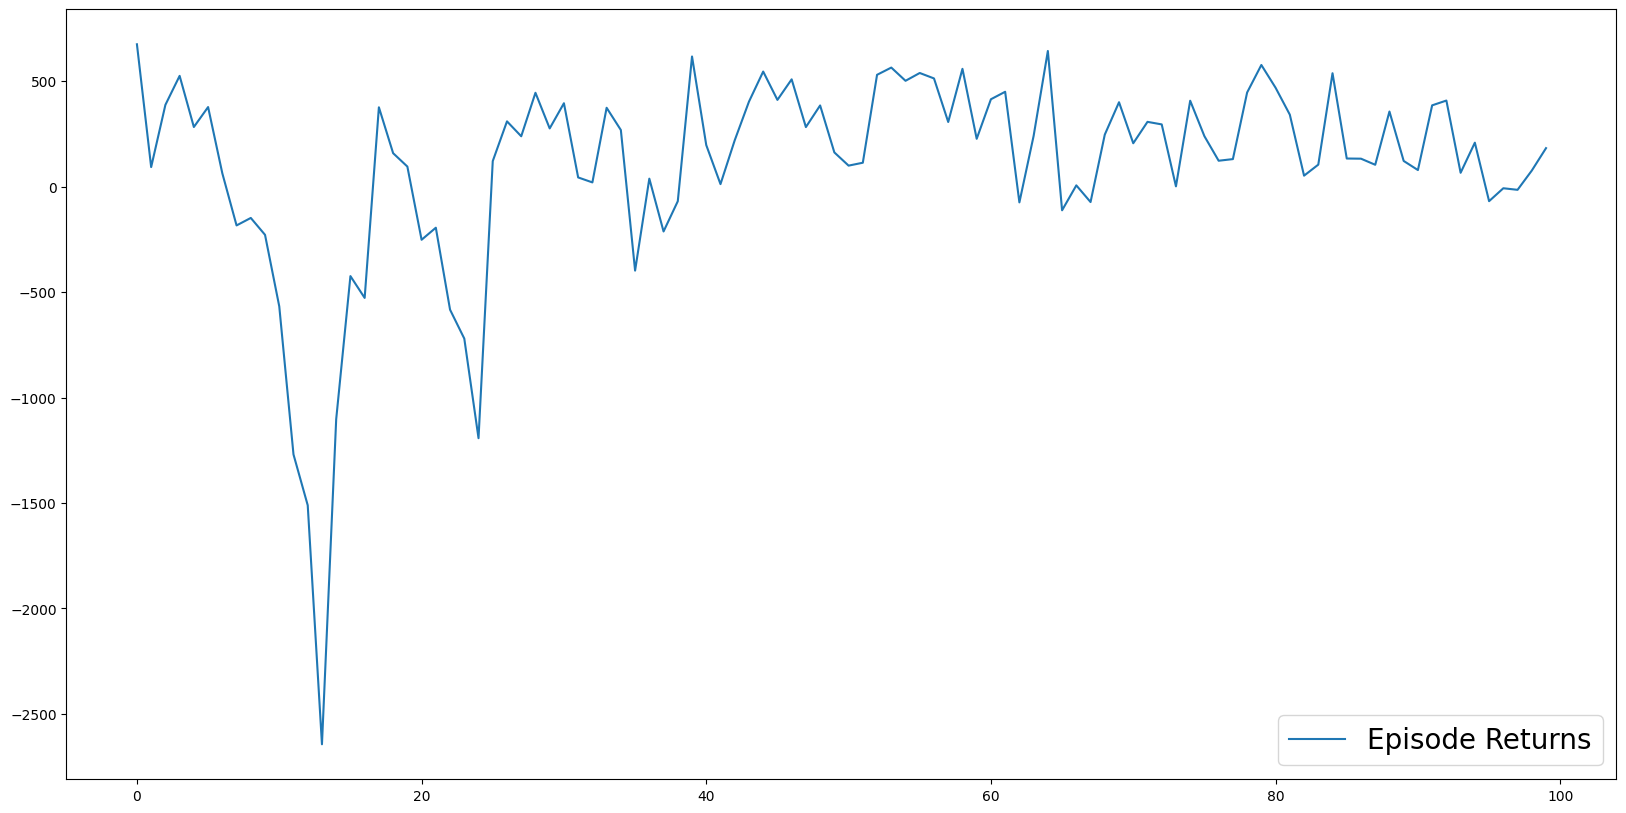

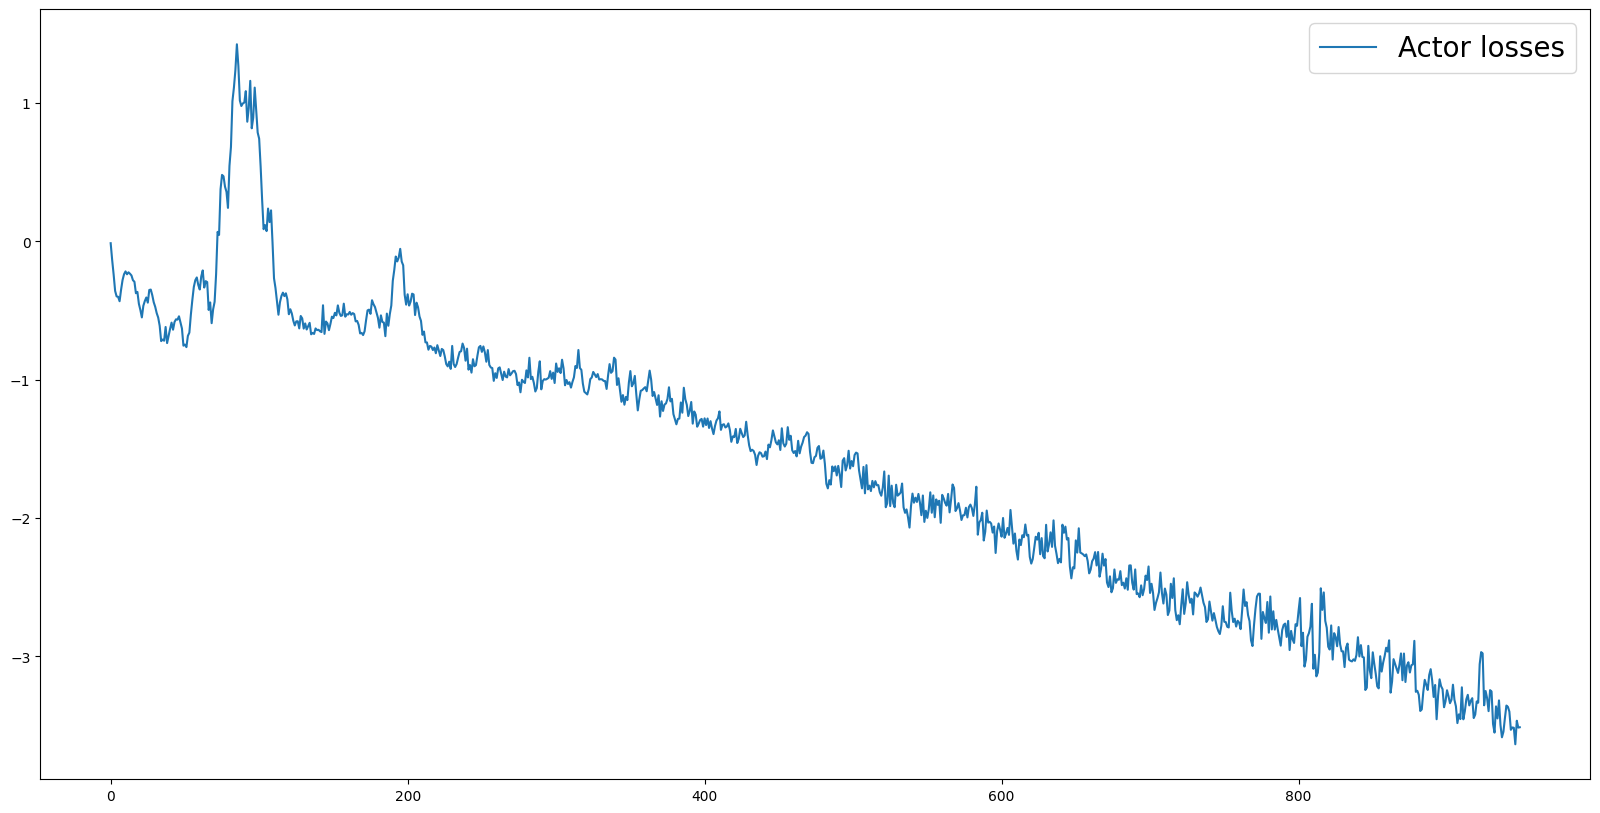

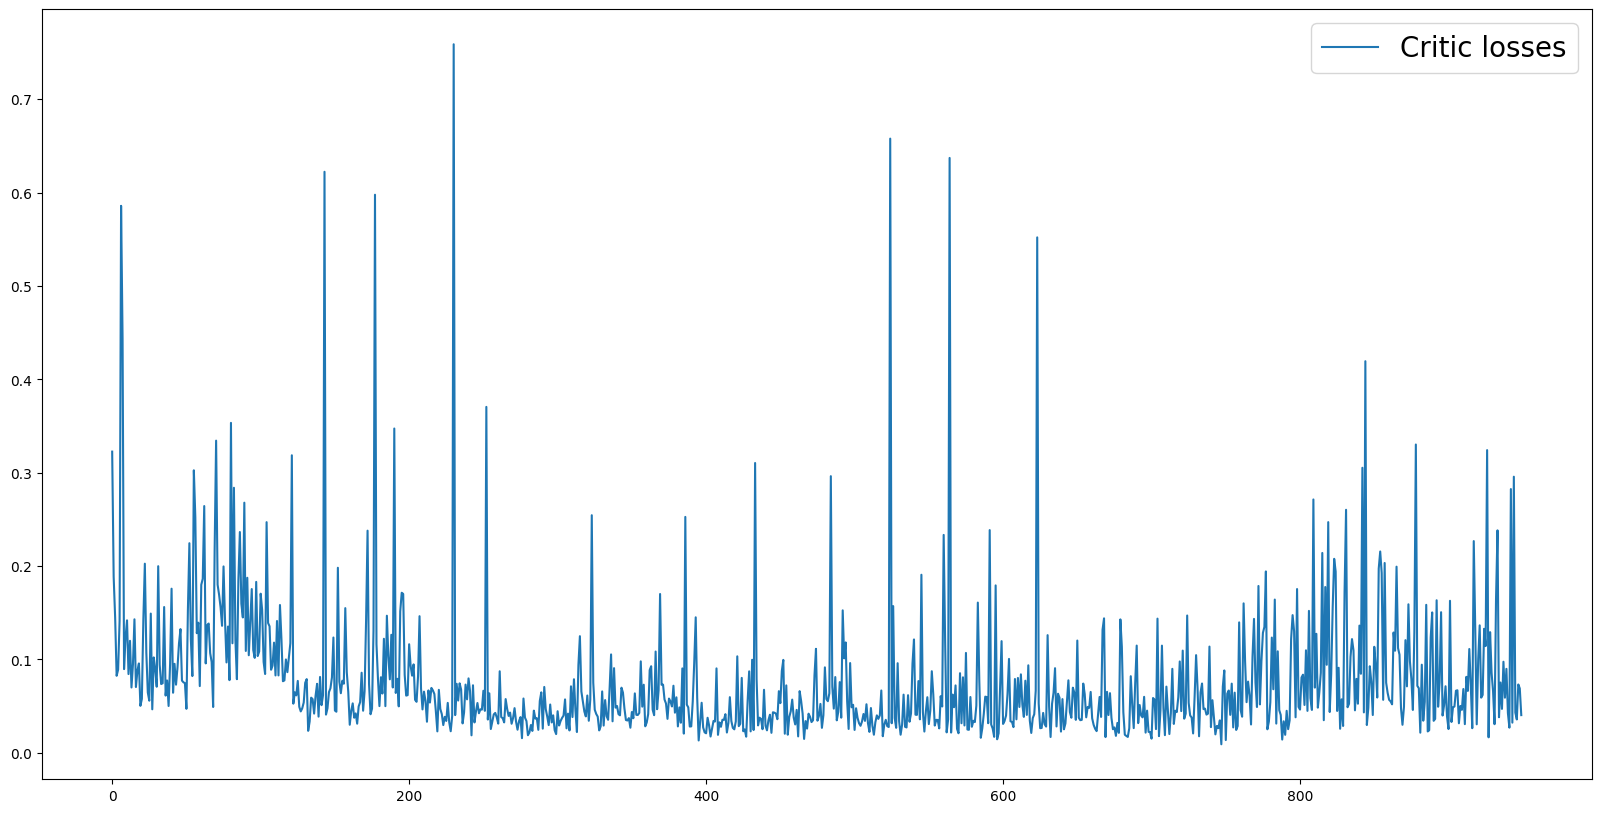

In [40]:
plt.figure(figsize=(20, 10))

# tensor = torch.Tensor(epi_rews).float().view(-1,10).mean(dim=1)
# epi_rews_np = tensor.detach().numpy()

plt.plot(epi_rews, label='Episode Returns')
plt.legend(fontsize=20)
plt.show()
plt.close()

plt.figure(figsize=(20, 10))
plt.plot(p_losses, label='Actor losses')
plt.legend(fontsize=20)
plt.show()
plt.close()

plt.figure(figsize=(20, 10))
plt.plot(q_losses, label='Critic losses')
plt.legend(fontsize=20)
plt.show()
plt.close()

In [ ]:
### 현 상황 저장하기 ###
save_path = "/content/drive/MyDrive/Colab Notebooks/DRL project/Ant_DDPG_att1.pth"
save_checkpoint(save_path, agent, epi_rews)

In [ ]:
### Replay buffer 초기화 하기 ###
agent.replay_buffer.memory = collections.deque(maxlen=100000)
epi_rews = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
### 비디오 디렉토리 초기화 ###
import os
import shutil

# Clean up previous video files to avoid conflicts
if os.path.exists('./Ant_DDPG_video'):
    shutil.rmtree('./Ant_DDPG_video')
os.makedirs('./Ant_DDPG_video')

In [ ]:
# Record video of the trained agent
agent.eval()

envs = gym.make(env_name, render_mode="rgb_array")
video_env = RecordVideo(envs, './Ant_DDPG_video', episode_trigger=lambda x: True)

state, _ = video_env.reset()
terminated = False
total_reward = 0.0

while not terminated:
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(agent.config.device)
    action = agent.actor(state_tensor).detach().cpu().numpy()[0]
    action = action + agent.action_noise()
    next_state, reward, terminated, info = video_env.step(action)

    total_reward += reward
    state = next_state

video_env.close()
print(total_reward)
show_video()